## guessing the best outlier detection method

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import pickle


warnings.filterwarnings('ignore')

In [58]:
data = pd.read_csv('../data/preprocessing_data.csv')  
data.drop(columns=['Unnamed: 0'], inplace= True)

In [59]:
X = data.drop(['diagnosis'], axis=1)
y = data['diagnosis']

In [60]:
skewed_cols = ['area_mean','compactness_mean','concavity_mean','concave points_mean','fractal_dimension_mean','radius_se',
 'texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se',
 'fractal_dimension_se','radius_worst','perimeter_worst','area_worst','compactness_worst','concavity_worst','symmetry_worst',
 'fractal_dimension_worst']

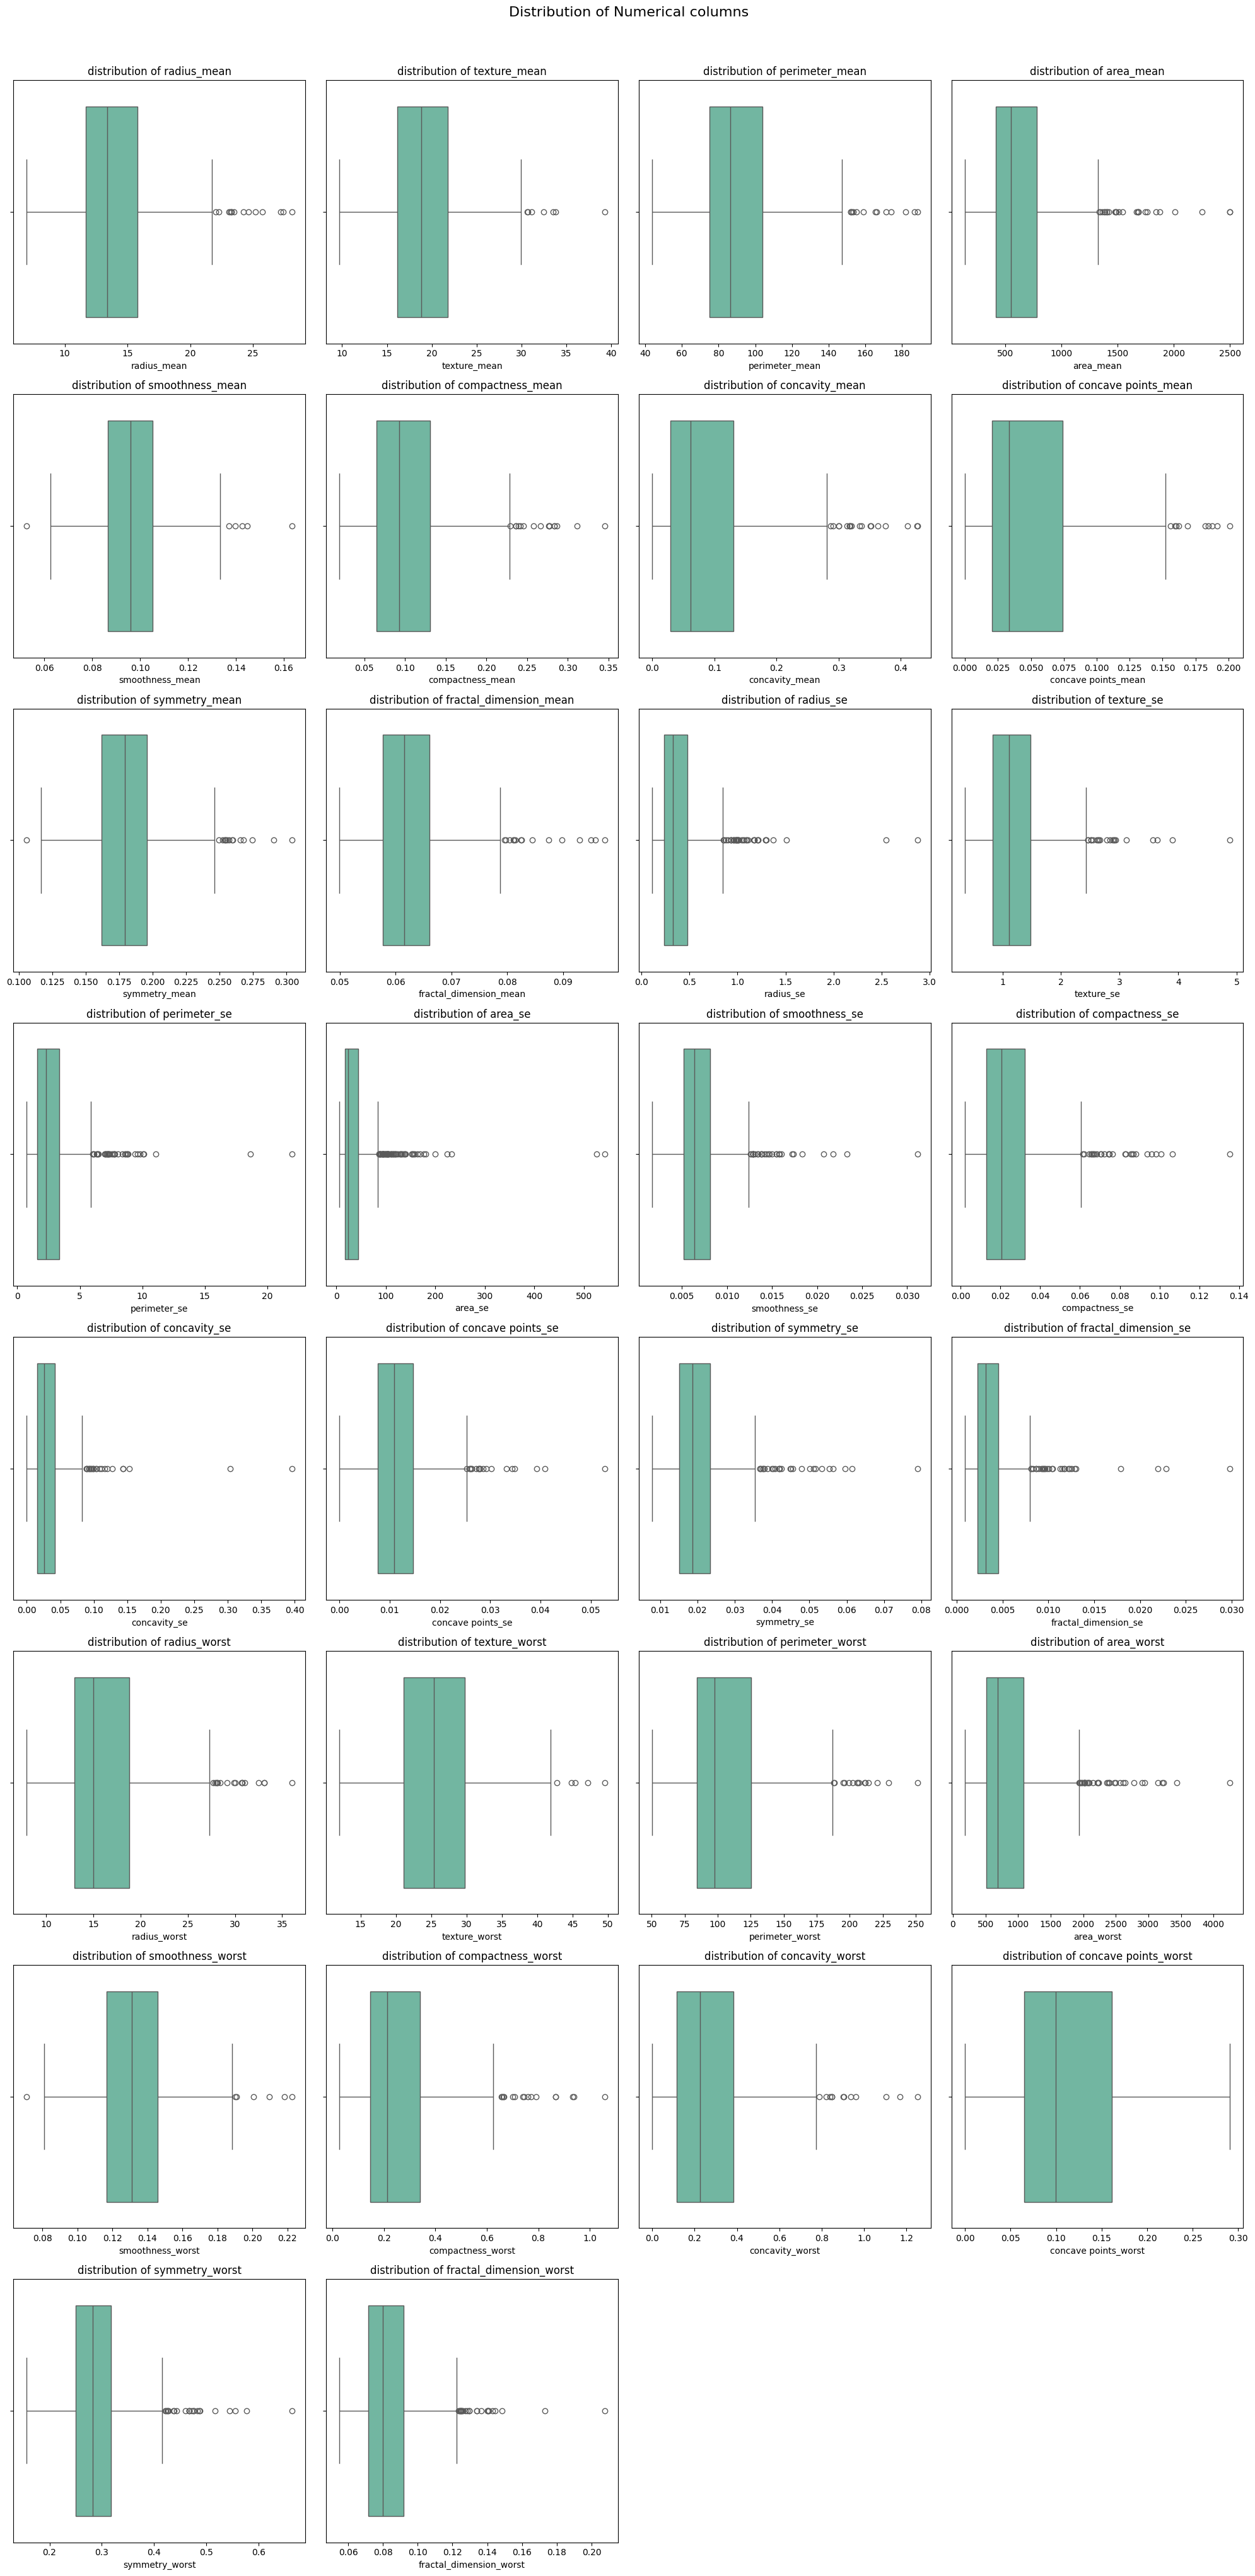

In [61]:
n = len(X.columns)
rows = int(np.ceil(n/4))

fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))

# Flatten the axes array, to make iterating over it easier
axs = axs.flatten()

for i, c in enumerate(list(X.columns)):
    sns.boxplot(x=X[c], ax=axs[i], palette='Set2')
    axs[i].set_title(f'distribution of {c}')

# Remove any unused subplots
if n % 4:
    for j in range(n, rows*4):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle('Distribution of Numerical columns', x=0.5, y=1.02, fontsize=16)
plt.show()

In [62]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred),2))
    print('Precision:', round(precision_score(y_test, y_pred),2))
    print('Recall:', round(recall_score(y_test, y_pred),2))
    print('F1 score:', round(f1_score(y_test, y_pred),2))

In [63]:
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [64]:
for col in X.columns:
    q1 = X[col].quantile(0.25)
    q3 = X[col].quantile(0.75)

    iqr = q3 - q1 

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    X_no_outliers = X[(X[col] >= lower) & (X[col] <= upper)]

y_no_outliers = y.loc[X_no_outliers.index]

In [65]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination=0.05,
    random_state=42
)

y_pred_outliers = iso.fit_predict(X)

mask = y_pred_outliers != -1
X_clean = X[mask]
y_clean = y[mask] 

In [66]:
X_clean

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,15.470,23.75,103.40,741.6,0.17910,0.52490,0.5355,0.1741,0.3985,0.12440
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.2542,0.2929,0.09873
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [67]:
X_no_outliers

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.2542,0.2929,0.09873
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


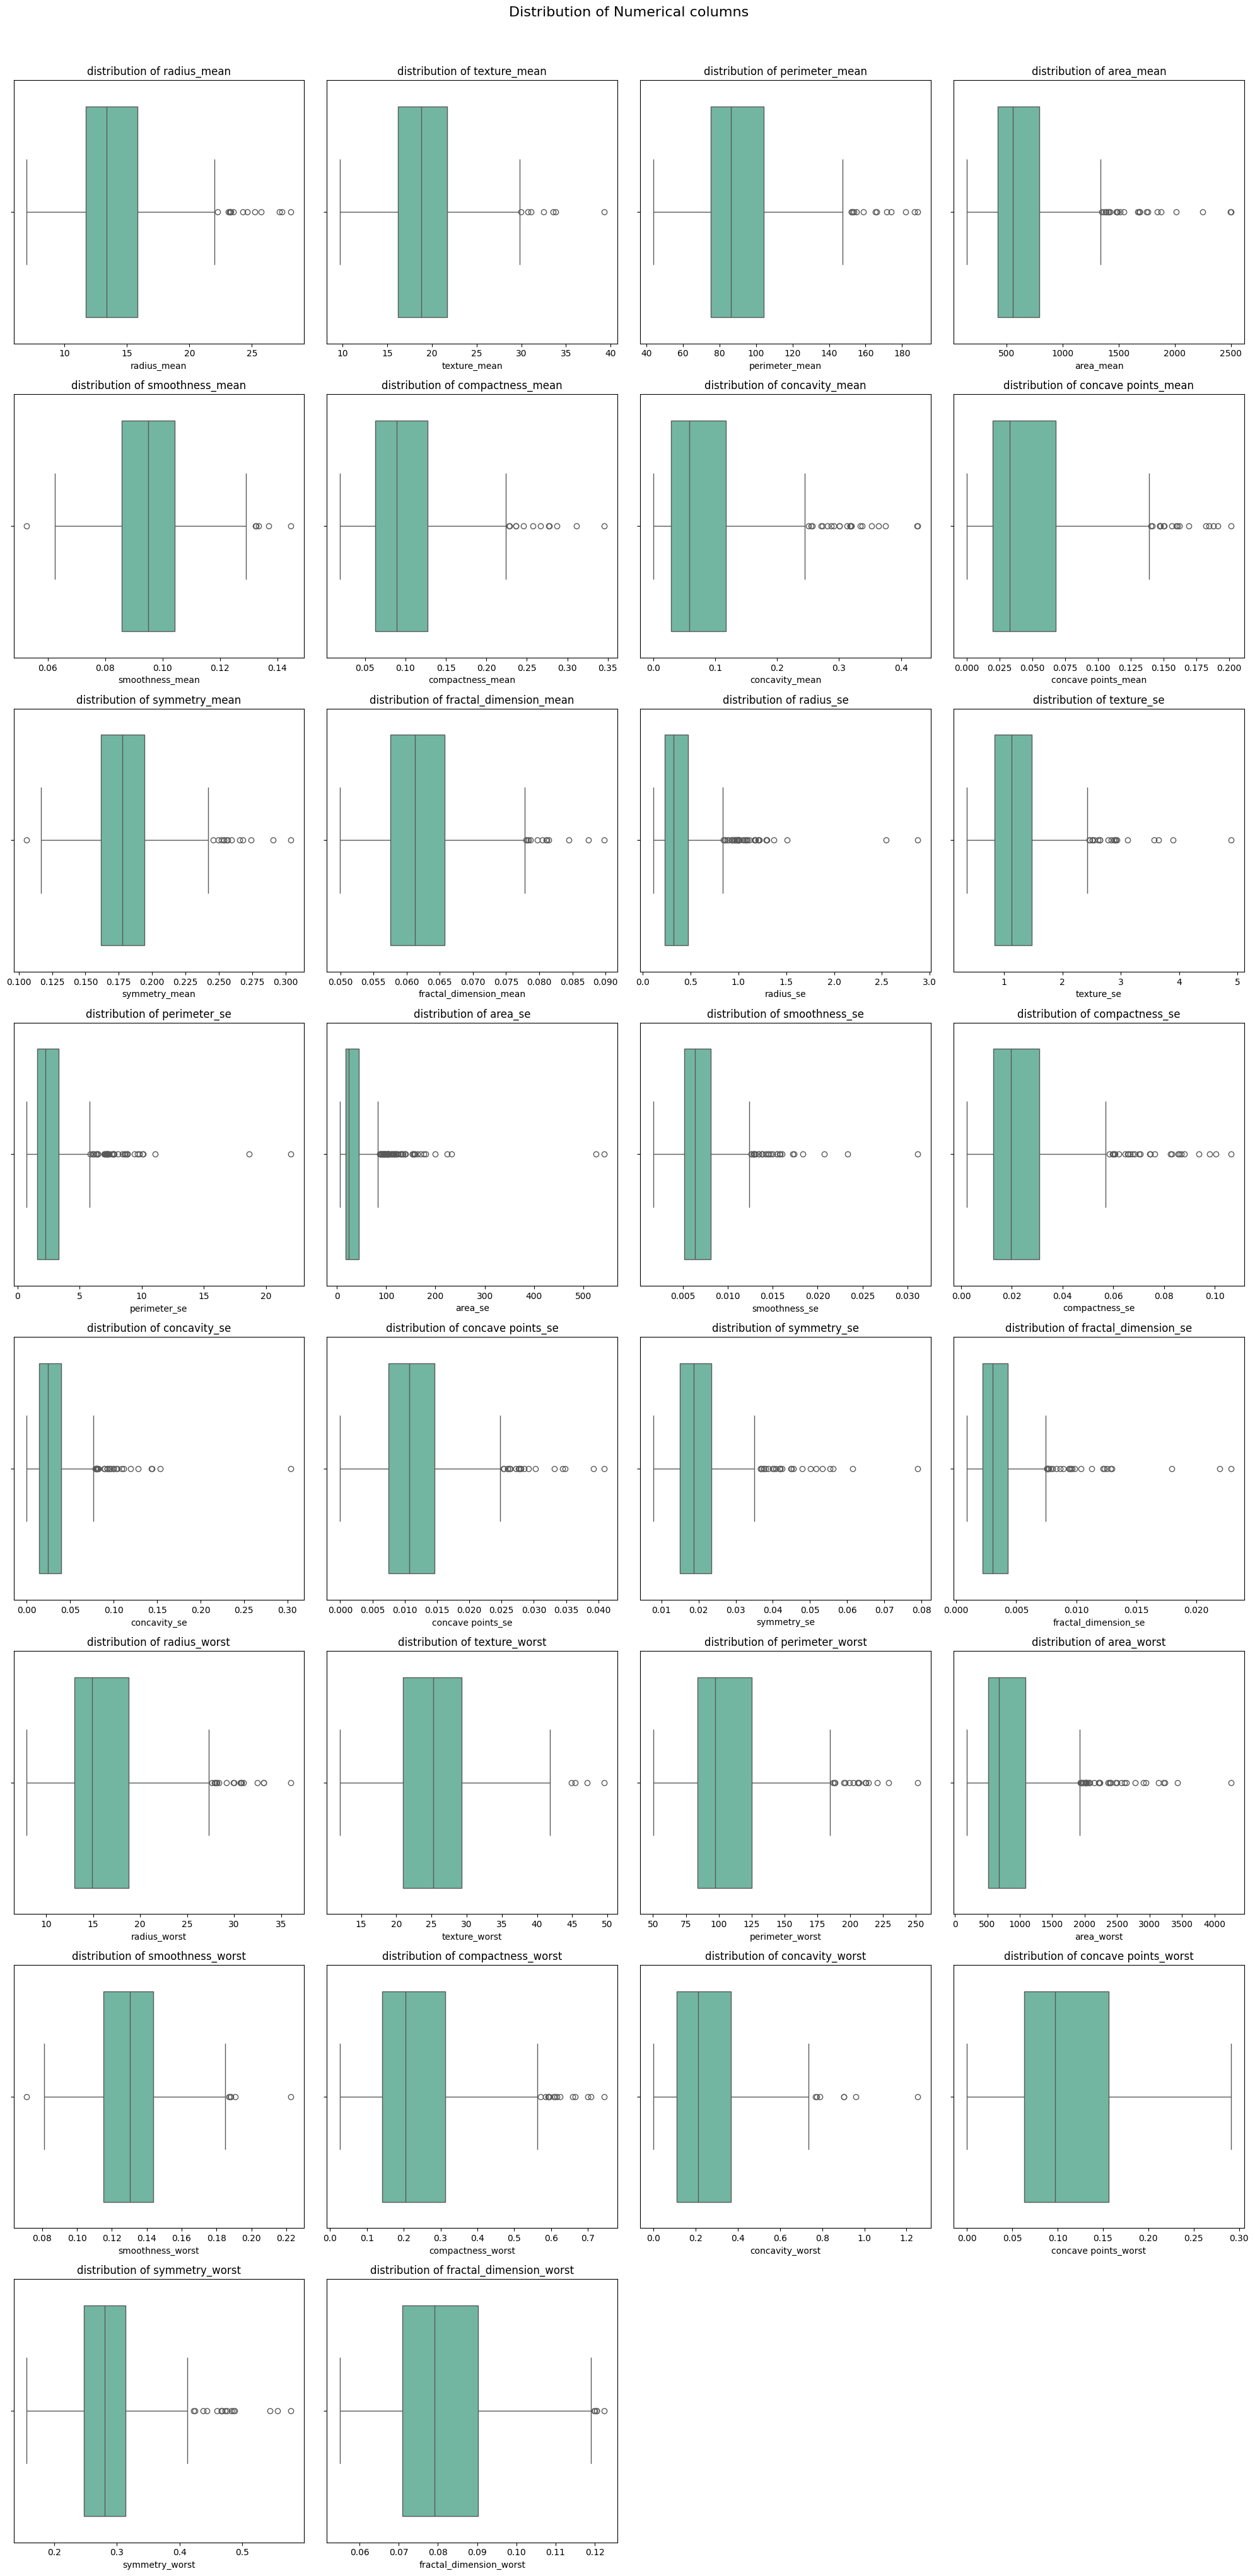

In [68]:
n = len(X_no_outliers.columns)
rows = int(np.ceil(n/4))

fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))

# Flatten the axes array, to make iterating over it easier
axs = axs.flatten()

for i, c in enumerate(list(X_no_outliers.columns)):
    sns.boxplot(x=X_no_outliers[c], ax=axs[i], palette='Set2')
    axs[i].set_title(f'distribution of {c}')

# Remove any unused subplots
if n % 4:
    for j in range(n, rows*4):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle('Distribution of Numerical columns', x=0.5, y=1.02, fontsize=16)
plt.show()

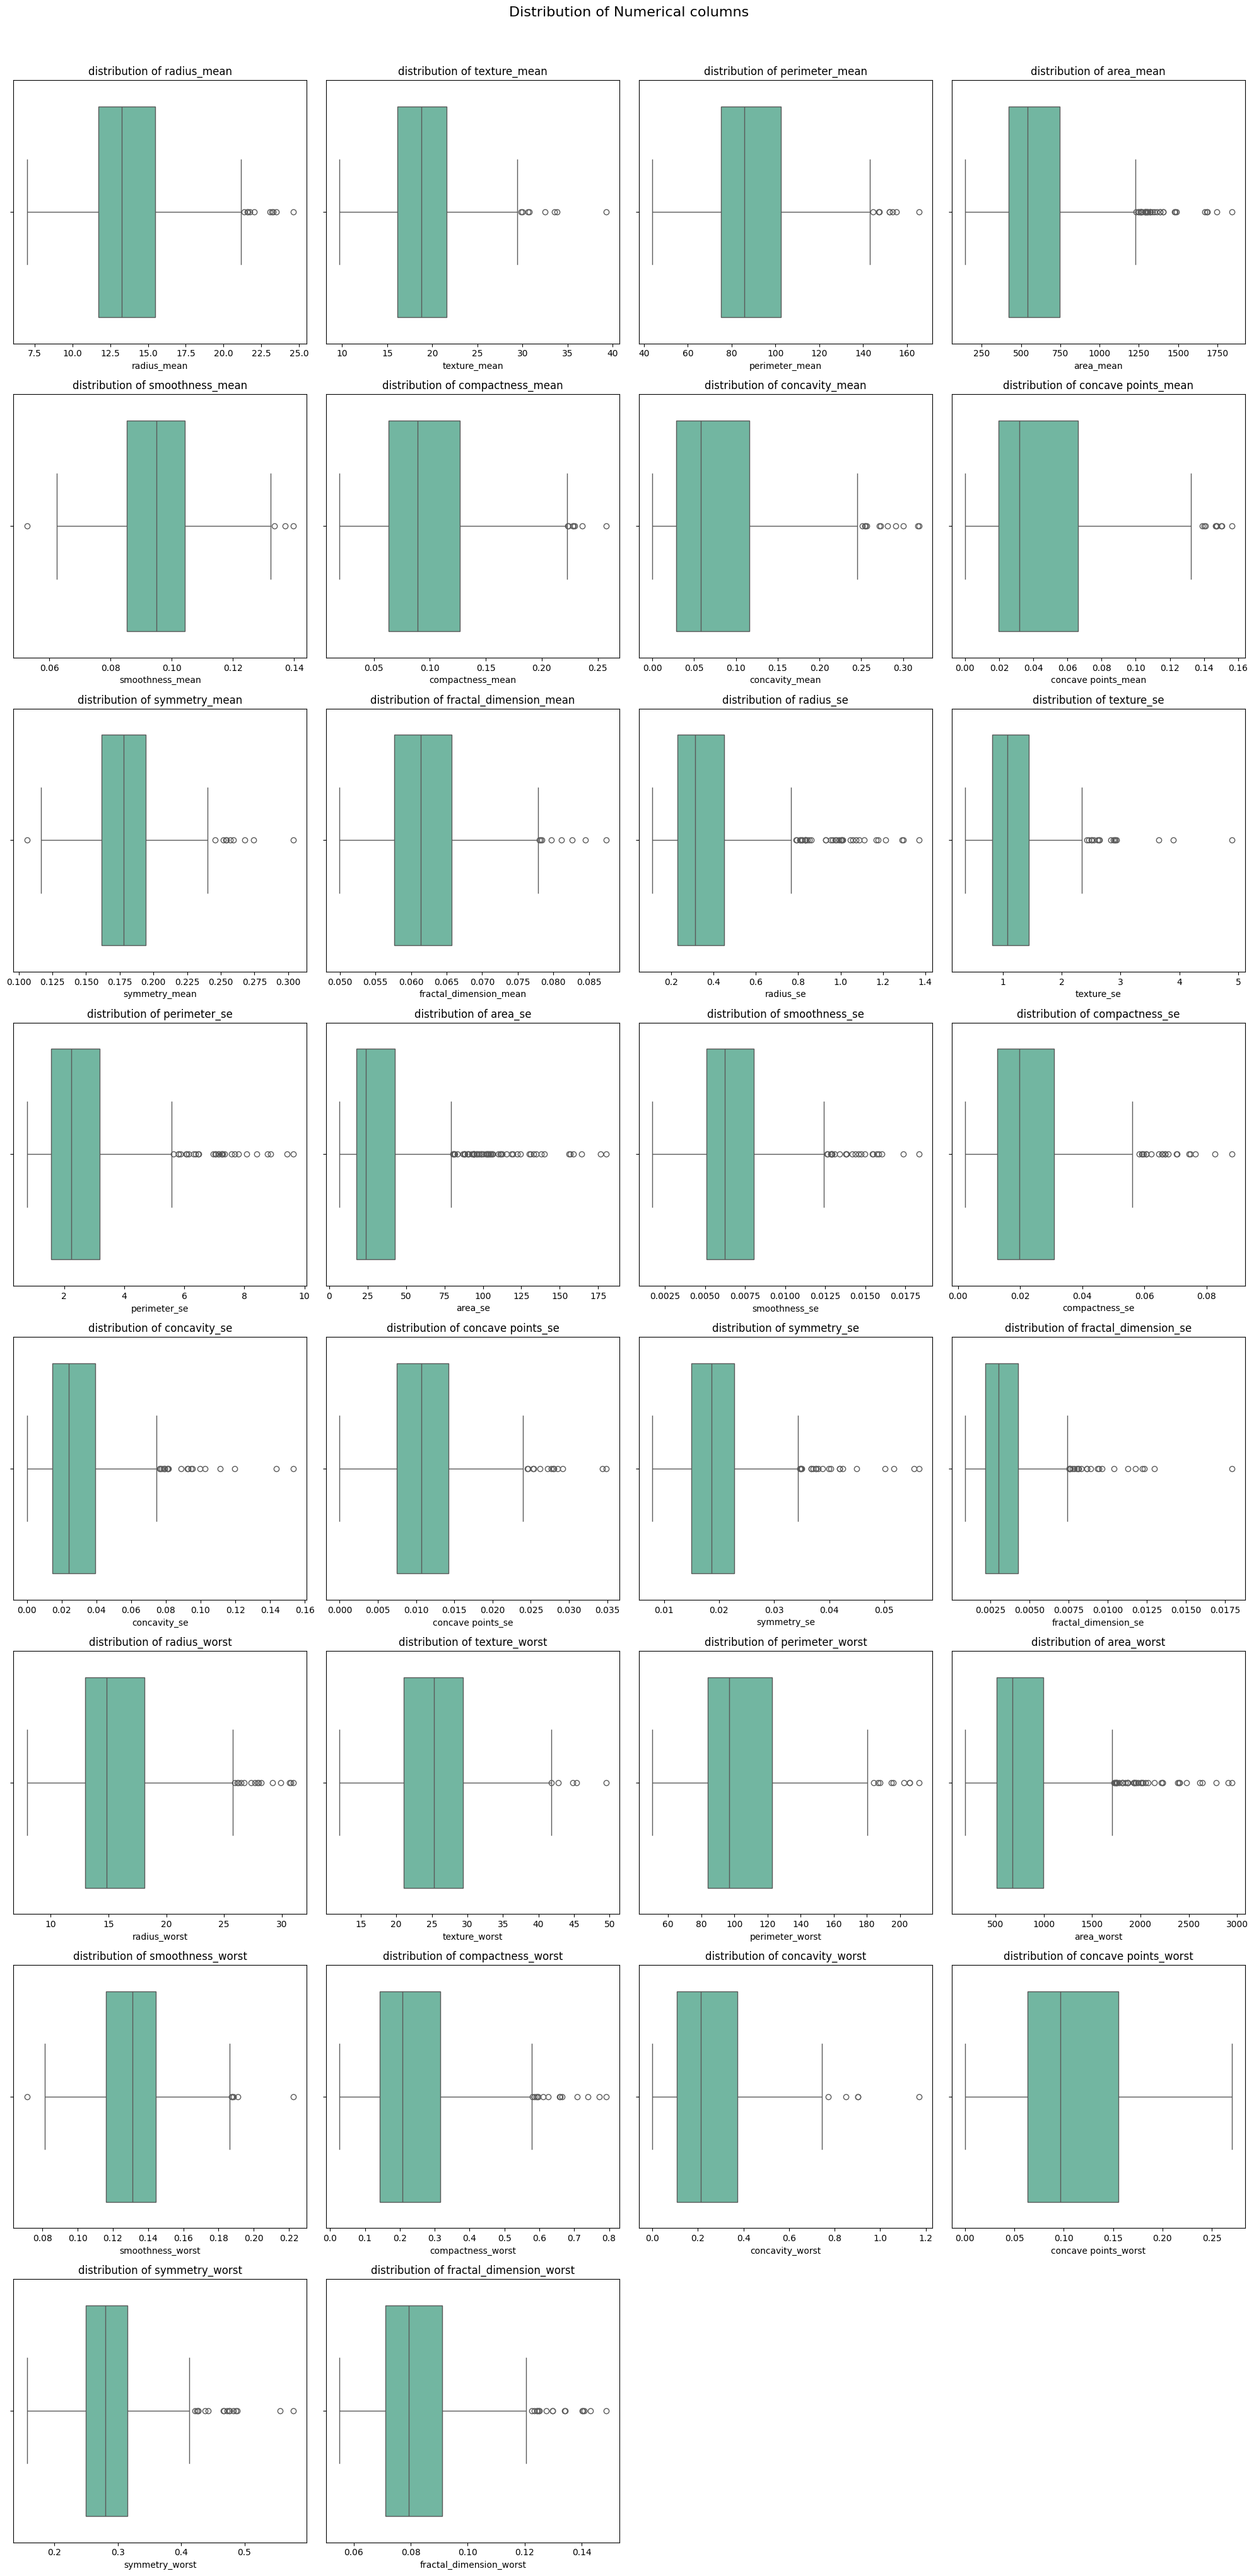

In [69]:
n = len(X_clean.columns)
rows = int(np.ceil(n/4))

fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))

# Flatten the axes array, to make iterating over it easier
axs = axs.flatten()

for i, c in enumerate(list(X_clean.columns)):
    sns.boxplot(x=X_clean[c], ax=axs[i], palette='Set2')
    axs[i].set_title(f'distribution of {c}')

# Remove any unused subplots
if n % 4:
    for j in range(n, rows*4):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle('Distribution of Numerical columns', x=0.5, y=1.02, fontsize=16)
plt.show()

In [70]:
with open('../models/log_reg.pkl', 'rb') as f:
    model = pickle.load(f)

In [71]:
model

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_transformer', ...), ('scaler', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [79]:
type(X_no_outliers)

pandas.core.frame.DataFrame

In [72]:
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

In [78]:
type(X_train_iqr)

pandas.core.frame.DataFrame

In [107]:
log_transformer = FunctionTransformer(np.log1p, validate= True)

scaler = StandardScaler()

pca = PCA(0.95)

preprocessor_iqr_data = ColumnTransformer(transformers=[('log_transformer', log_transformer, skewed_cols), 
                                               ('scaler', scaler, X.columns),
                                                ("pca", pca, X.columns)])

pipeline_iqr = Pipeline(steps=[('preprocessor', preprocessor_iqr_data),
                           ('model', LogisticRegression(random_state=42, max_iter=500))])

pipeline_iqr.fit(X_train_iqr, y_train_iqr)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_transformer', ...), ('scaler', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [110]:
evaluate_model(pipeline_iqr, X_test_iqr, y_test_iqr)

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 score: 0.98


In [105]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [108]:
log_transformer = FunctionTransformer(np.log1p, validate= True)

scaler = StandardScaler()

pca = PCA(0.95)

preprocessor_iqr_data = ColumnTransformer(transformers=[('log_transformer', log_transformer, skewed_cols), 
                                               ('scaler', scaler, X_train_m.columns),
                                                ("pca", pca, X_train_m.columns)])

pipeline_m = Pipeline(steps=[('preprocessor', preprocessor_iqr_data),
                           ('model', LogisticRegression(random_state=42, max_iter=500))])

pipeline_m.fit(X_train_m, y_train_m)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_transformer', ...), ('scaler', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [109]:
evaluate_model(pipeline_m, X_test=X_test_m, y_test= y_test_m)

Accuracy: 0.97
Precision: 0.97
Recall: 0.94
F1 score: 0.96
